First, load the data,in this notebook we are using the PMI data from the paper:"Environmental predictors impact microbialbased postmortem interval (PMI) estimation models within human decomposition soils". The preprocessed data includes OTU/phylum/class/order abundance matrices (includes or not include environmental factors)

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric



2025-01-17 12:20:04.014060: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 12:20:04.017035: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 12:20:04.021758: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 12:20:04.033773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737134404.055186 2801732 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737134404.06

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle
import matplotlib.pyplot as plt
import glob
import os

In [3]:
PMIdata_path = '../data/count_table/'

## No env model
16s (OTU/phylum/class/order) - no env

ITS (OTU/phylum/class/order) - no env

16s+ITS (OTU/phylum/class/order) - no env (only use this data when calculating H)
bact.ITS.n.class.env

### Data preprocess


In [4]:
bact_ITS_noenv_files = glob.glob(PMIdata_path + 'bact.n.*.noenv.csv')

In [5]:
bact_ITS_noenv_files

['../data/count_table/bact.n.otu.noenv.csv',
 '../data/count_table/bact.n.order.noenv.csv',
 '../data/count_table/bact.n.class.noenv.csv',
 '../data/count_table/bact.n.phylum.noenv.csv']

In [6]:
# Read each CSV file into a list of dataframes
bact_ITS_noenv_df_list = [pd.read_csv(file) for file in bact_ITS_noenv_files]
taxlabels = ['OTU', 'order', 'class', 'phylum']

In [7]:
for df in bact_ITS_noenv_df_list:
    print(df.shape)
    


(78, 5196)
(78, 265)
(78, 112)
(78, 36)


In [8]:
# target variable
y = bact_ITS_noenv_df_list[3].iloc[:, 0].values 

# Define the threshold
y_threshold = 2500

# Categorize the series based on the threshold
y = np.where(y > y_threshold, 'LONG', 'SHORT')

print(y)

print(list(y).count('LONG'))
print(list(y).count('SHORT'))

['SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT'
 'SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'LONG' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'LONG'
 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG']
35
43


In [9]:
bact_ITS_noenv_df_list[3]

,ADH_10_actual,Proteobacteria,Verrucomicrobia,Acidobacteria,Actinobacteria,Firmicutes,Bacteroidetes,Chloroflexi,Rokubacteria,Entotheonellaeota,...,FBP,Fibrobacteres,Hydrogenedentes,Spirochaetes,Tenericutes,Deinococcus-Thermus,Omnitrophicaeota,FCPU426,WS4,Kiritimatiellaeota
0,0.00000,2405.899397,957.553453,1988.986693,2524.409168,92.418396,311.448621,526.359155,123.316076,99.009901,...,1.647876,3.158430,0.686615,0.000000,0.000000,0.000000,2.883784,0.686615,0.000000,0.137323
1,1484.14700,3209.276660,757.215776,1727.647573,1840.003679,226.398320,680.881068,465.059244,117.874278,67.904168,...,0.459848,1.379543,0.459848,0.153283,0.000000,0.000000,1.532825,0.306565,0.000000,0.000000
2,1989.56009,3829.070365,412.942989,821.982537,1300.667694,389.111454,2416.230098,276.938880,48.073960,41.088855,...,0.000000,0.410889,0.616333,0.000000,0.000000,0.000000,0.616333,0.000000,0.000000,0.410889
3,2973.68000,3194.403374,419.280034,848.987596,1688.948376,1069.522046,1868.083981,287.613030,65.055328,42.488288,...,0.622539,2.023252,0.466904,0.000000,0.000000,0.466904,0.311270,0.000000,0.155635,0.000000
4,4027.69203,3694.823154,475.772750,833.851140,1209.230357,465.538458,2514.224448,230.271574,60.065548,51.049624,...,0.731021,0.852858,2.436736,0.000000,0.609184,0.000000,0.487347,0.000000,0.121837,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,4447.32241,2456.386357,702.629879,1096.355563,2612.831828,1416.120207,209.098033,519.102019,161.669485,29.144499,...,0.000000,2.474533,0.000000,0.000000,0.000000,0.000000,0.137474,0.000000,0.000000,0.000000
74,0.00000,2919.908680,1004.519405,1906.070913,954.200252,28.421004,1003.432263,630.853096,87.437295,19.413254,...,1.553060,3.882651,1.863672,1.397754,0.155306,0.000000,4.193263,0.155306,0.621224,1.087142
75,1477.74800,4411.744255,735.145847,1127.142509,1262.559538,178.006467,886.381810,434.238431,128.985155,45.718458,...,0.000000,0.347669,0.173834,0.347669,0.000000,0.173834,0.869172,0.173834,0.521503,0.347669
76,2554.43400,2821.384741,962.492330,1377.965842,1773.368787,586.137247,543.055840,570.541010,179.740233,65.964410,...,0.511352,0.639190,0.894866,0.000000,0.255676,0.000000,0.767028,0.000000,0.127838,0.383514


In [10]:
df_list = []
col_names_4taxa=[]
for df in bact_ITS_noenv_df_list:
    data = df.drop(df.columns[0], axis=1)# delete the response column
    df_list.append(data)
    cols_name = df.columns
    col_names_4taxa.append(cols_name)

#### OTU

##### 1. calculate H statistics for OTU/phylum/class/order (both 16s and ITS)

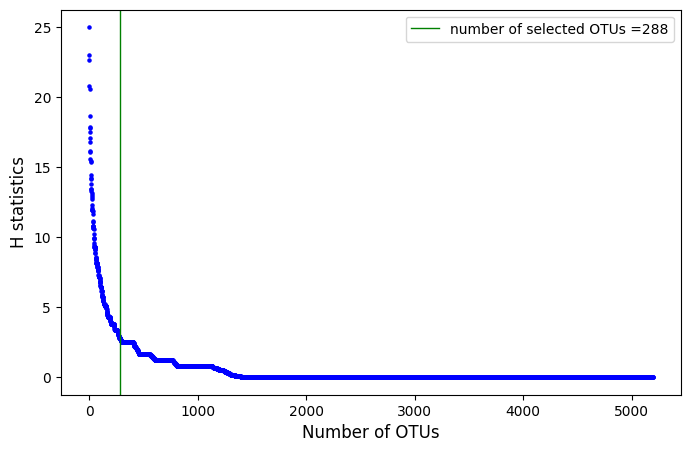

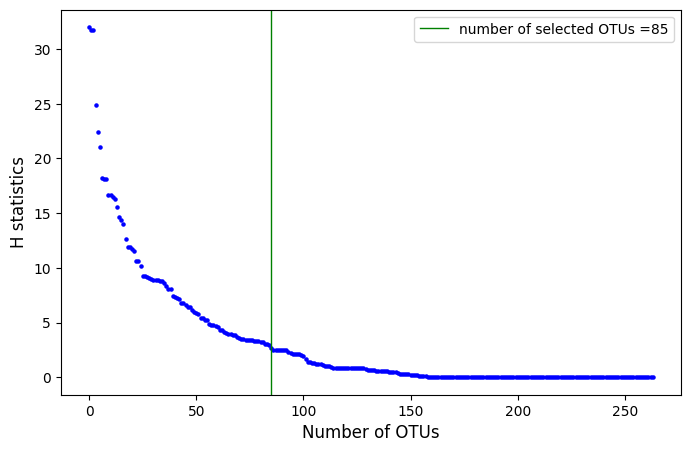

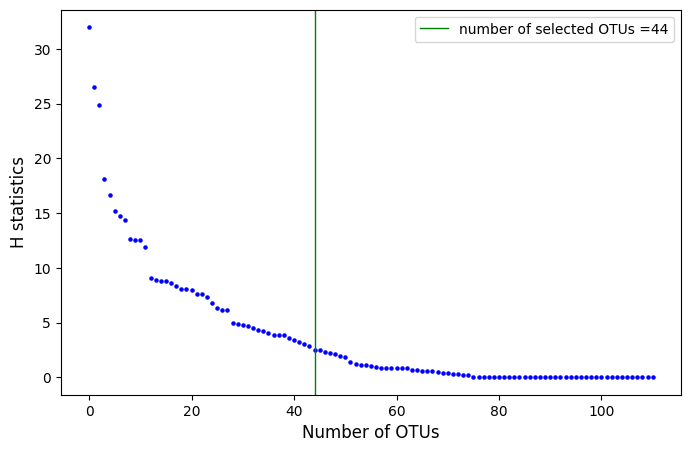

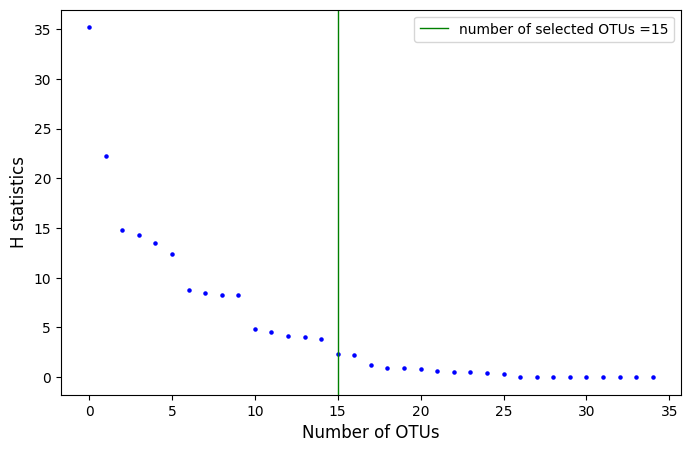

In [11]:
data_4taxa = []
weights_4taxa = []
selectedOTU_index_4tax = []
X_FS_4taxa = []
selectedASVs_4taxa = []
eps_4tax = []
for df in df_list:
    select_result = FS.SelectMicro_fun(df,y,threshold=0.001)
    data_4taxa.append(select_result['relative_abundance_data'])
    weights_4taxa.append(select_result['H_score'])
    selectedOTU_index_4tax.append(select_result['selected_indices'])
    X_FS_4taxa.append(select_result['selected_data'])
    selectedASVs_4taxa.append(select_result['selected_columnames'])
    eps = len(select_result['selected_indices'])
    eps_4tax.append(eps)

In [12]:
print(eps_4tax)

[288, 85, 44, 15]


In [13]:
for weight in weights_4taxa:
    print(len(weight))

5195
264
111
35


In [14]:
max(weights_4taxa[3])

35.19309474746626

In [15]:
len(selectedOTU_index_4tax)

4

In [16]:
for i in range(4):
    print(f"Selected features in {taxlabels[i]} : {selectedASVs_4taxa[i]}")

Selected features in OTU : Index(['Otu00009', 'Otu00003', 'Otu00008', 'Otu00001', 'Otu00150', 'Otu00012',
       'Otu00129', 'Otu00021', 'Otu00273', 'Otu00036',
       ...
       'Otu00626', 'Otu00179', 'Otu00284', 'Otu00315', 'Otu00918', 'Otu01027',
       'Otu00789', 'Otu00859', 'Otu00298', 'Otu00473'],
      dtype='object', length=288)
Selected features in order : Index(['Clostridiales', 'Bacteroidales', 'Lactobacillales', 'Selenomonadales',
       'Bacilli_unclassified', 'Cardiobacteriales', 'Bacillales',
       'Thermoanaerobaculales', 'Pedosphaerales', 'Subgroup_6_or',
       'Enterobacteriales', 'Blastocatellales', 'Chitinophagales',
       'Cytophagales', 'Bacteria_unclassified', 'Nitrospirales', 'Subgroup_7',
       'Subgroup_5_or', 'Corynebacteriales', 'Latescibacteria_or',
       'Phycisphaerales', 'Bacteroidia_unclassified', 'Pyrinomonadales',
       'Solibacterales', 'Opitutales', 'Pseudomonadales', 'Streptomycetales',
       'Verrucomicrobiales', 'Subgroup_22_or', 'Oligof

##### 2. Select indices of the features based on H statistics and form the subset based on the selected features.
The default p value of the function is 10%, the resulted index is ranked by its H statistics descendingly.

Use "indice_H_unisig" if there is only one response, use "indice_H_multisig" for multiple responses.

weights_4taxa,selectedOTU_index_4tax,col_names_4taxa,eps_4tax

In [17]:
#plot the h statistics and cutoff descendingly
#for i in range(len(weights_4taxa)):
    #FS.plotWeightedIndex(weights_4taxa[i],threshold=eps_4tax[i])

#### 4. Model
Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method)

Use random forest and SVM as classifier, and will build both models for each response variable.

For Lasso, the dataset will be determined by the response variable, so the lasso subset is different for the models for different response variables.

For random selection, the  process will repeat iter=30 times to  find the mean accuracy and AUC

SMOTE  is used (the data is not balanced, as we can see the performance is really bad especially for SVM model when not using SMOTE)

In [18]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [19]:
targetLabel=y

In [20]:
data_subset_4taxa = []
X_lasso_4taxa = []
X_lasso_ft_4taxa = []
xind_lasso_4taxa = []
xind_lasso_ft_4taxa = []
for i, data  in enumerate(data_4taxa):
    X_lasso,xind_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)
    X_lasso_ft,xind_lasso_ft = RunML_continue.LassoFS_CV(data,targetLabel)
    X_lasso_4taxa.append(X_lasso)
    X_lasso_ft_4taxa.append(X_lasso_ft)
    xind_lasso_4taxa.append(xind_lasso)
    xind_lasso_ft_4taxa.append(xind_lasso_ft)
    data_subset = {"AllFeatures":data, 
                "SelectMicro": X_FS_4taxa[i],
                "Lasso":X_lasso,
                "Lasso_finetune":X_lasso_ft
              }
    data_subset_4taxa.append(data_subset)

Best alpha: 0.1
Best alpha: 0.1


/lustre/isaac/scratch/mhe8/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e-03, tolerance: 1.510e-03
  model = cd_fast.enet_coordinate_descent(


Best alpha: 0.05
Best alpha: 0.05


In [21]:
for i, dataset  in enumerate(data_subset_4taxa):
    data_subset = dataset
    print(taxlabels[i])
    for datatype, subset in data_subset.items():
        print(np.shape(subset))

OTU
(78, 5195)
(78, 288)
(78, 39)
(78, 15)
order
(78, 264)
(78, 85)
(78, 16)
(78, 9)
class
(78, 111)
(78, 44)
(78, 14)
(78, 14)
phylum
(78, 35)
(78, 15)
(78, 6)
(78, 6)


In [22]:
with open('../data/data_subset_4taxa_paperthreshold_bac.pkl', 'wb') as file:
    pickle.dump(data_subset_4taxa, file)

In [23]:
X_FS_lasso_4taxa = []
selectedOTU_index_FS_lasso_4taxa = []
X_FS_lassoft_4taxa = []
selectedOTU_index_FS_lassoft_4taxa = []

data_FS_lasso_4taxa = []

for i, data  in enumerate(data_4taxa):
    print(taxlabels[i])
        
    X_FS = X_FS_4taxa[i]
    
    X_FS_lasso,xlabel_FS_lasso = RunML_continue.LassoFeatureSelection(X_FS,targetLabel)# this is depend on the target variable(do not update here)
    X_FS_lasso_4taxa.append(X_FS_lasso)
    selectedOTU_index_FS_lasso_4taxa.append(np.array(selectedOTU_index_4tax[i])[xlabel_FS_lasso])

    X_FS_lasso_ft,xlabel_FS_lasso_ft  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
    X_FS_lassoft_4taxa.append(X_FS_lasso_ft)
    selectedOTU_index_FS_lassoft_4taxa.append(np.array(selectedOTU_index_4tax[i])[xlabel_FS_lasso_ft])
    
    
    data_subset = {"FS_Lasso":X_FS_lasso,
                "FS_Lassofinetune":X_FS_lasso_ft}

    data_FS_lasso_4taxa.append(data_subset)
    
    print(f'The shape of the FS_Lasso selected dataset is ',np.shape(X_FS_lasso))
    print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))


OTU
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 28)
The shape of the FS_Lasso_finetune selected dataset is  (78, 28)
order
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 12)
The shape of the FS_Lasso_finetune selected dataset is  (78, 12)
class
Best alpha: 0.01
The shape of the FS_Lasso selected dataset is  (78, 12)
The shape of the FS_Lasso_finetune selected dataset is  (78, 22)
phylum
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (78, 6)
The shape of the FS_Lasso_finetune selected dataset is  (78, 6)


In [24]:
with open('../data/data_FS_lasso_4taxa_paperthreshold_bac.pkl', 'wb') as file:
    pickle.dump(data_FS_lasso_4taxa, file)

In [25]:
#with open('../data/data_AE_4taxa.pkl', 'wb') as file:
#    pickle.dump(data_AE_4taxa, file)

### Fisher_discriminant_ratio

The Fisher Discriminant Ratio is a measure used in statistics and machine learning to evaluate the separability between two or more classes. It is commonly used in Linear Discriminant Analysis (LDA) to reduce dimensionality while preserving as much of the class discriminatory information as possible.

Fisher's Criterion / Fisher's Discriminant Ratio
Fisher's discriminant ratio evaluates how well the classes can be separated based on the ratio of the between-class scatter matrix to the within-class scatter matrix.

In [26]:
for i in range(len(taxlabels)):
    print(f"Analysis of {taxlabels[i]}")
    for datatype, subset in data_subset_4taxa[i].items():
        print(f"f1 of {datatype} = {metric.fisher_discriminant_ratio(subset,targetLabel)}")
    for datatype, subset in data_FS_lasso_4taxa[i].items():
        print(f"f1 of {datatype} = {metric.fisher_discriminant_ratio(subset,targetLabel)}")


Analysis of OTU
f1 of AllFeatures = 0.03183365386038948
f1 of SelectMicro = 0.04554220364657397
f1 of Lasso = 0.08151434388371523
f1 of Lasso_finetune = 0.25939616683255273
f1 of FS_Lasso = 0.0813705972833109
f1 of FS_Lassofinetune = 0.0813705972833109
Analysis of order
f1 of AllFeatures = 0.09653698799817362
f1 of SelectMicro = 0.13435158746113401
f1 of Lasso = 0.3389545977662726
f1 of Lasso_finetune = 0.3334961123969269
f1 of FS_Lasso = 0.3479073336916026
f1 of FS_Lassofinetune = 0.3479073336916026
Analysis of class
f1 of AllFeatures = 0.0876326023923504
f1 of SelectMicro = 0.16975084304921073
f1 of Lasso = 0.21881804088814175
f1 of Lasso_finetune = 0.21881804088814175
f1 of FS_Lasso = 0.3246514549453245
f1 of FS_Lassofinetune = 0.282321667550591
Analysis of phylum
f1 of AllFeatures = 0.16043817944895913
f1 of SelectMicro = 0.3130797043935696
f1 of Lasso = 0.451312517102751
f1 of Lasso_finetune = 0.451312517102751
f1 of FS_Lasso = 0.451312517102751
f1 of FS_Lassofinetune = 0.45131251

### compare the first 15 index by their present ratio

Index(['Otu00009', 'Otu00003', 'Otu00008', 'Otu00001', 'Otu00150', 'Otu00012',
       'Otu00129', 'Otu00021', 'Otu00273', 'Otu00036', 'Otu00015', 'Otu00037',
       'Otu00010', 'Otu00174', 'Otu00096'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   Otu00009      0.257143      0.790698
1   Otu00003      0.142857      0.000000
2   Otu00008      0.285714      0.000000
3   Otu00001      0.285714      0.093023
4   Otu00150      0.000000      0.000000
5   Otu00012      0.057143      0.000000
6   Otu00129      0.000000      0.000000
7   Otu00021      0.028571      0.000000
8   Otu00273      0.000000      0.000000
9   Otu00036      0.114286      0.000000
10  Otu00015      0.171429      0.023256
11  Otu00037      0.228571      0.046512
12  Otu00010      0.171429      0.023256
13  Otu00174      0.000000      0.000000
14  Otu00096      0.028571      0.000000


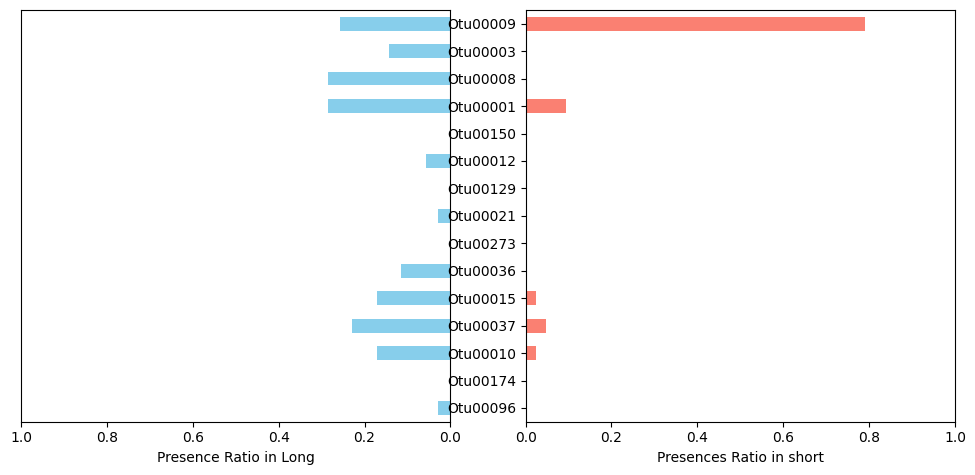

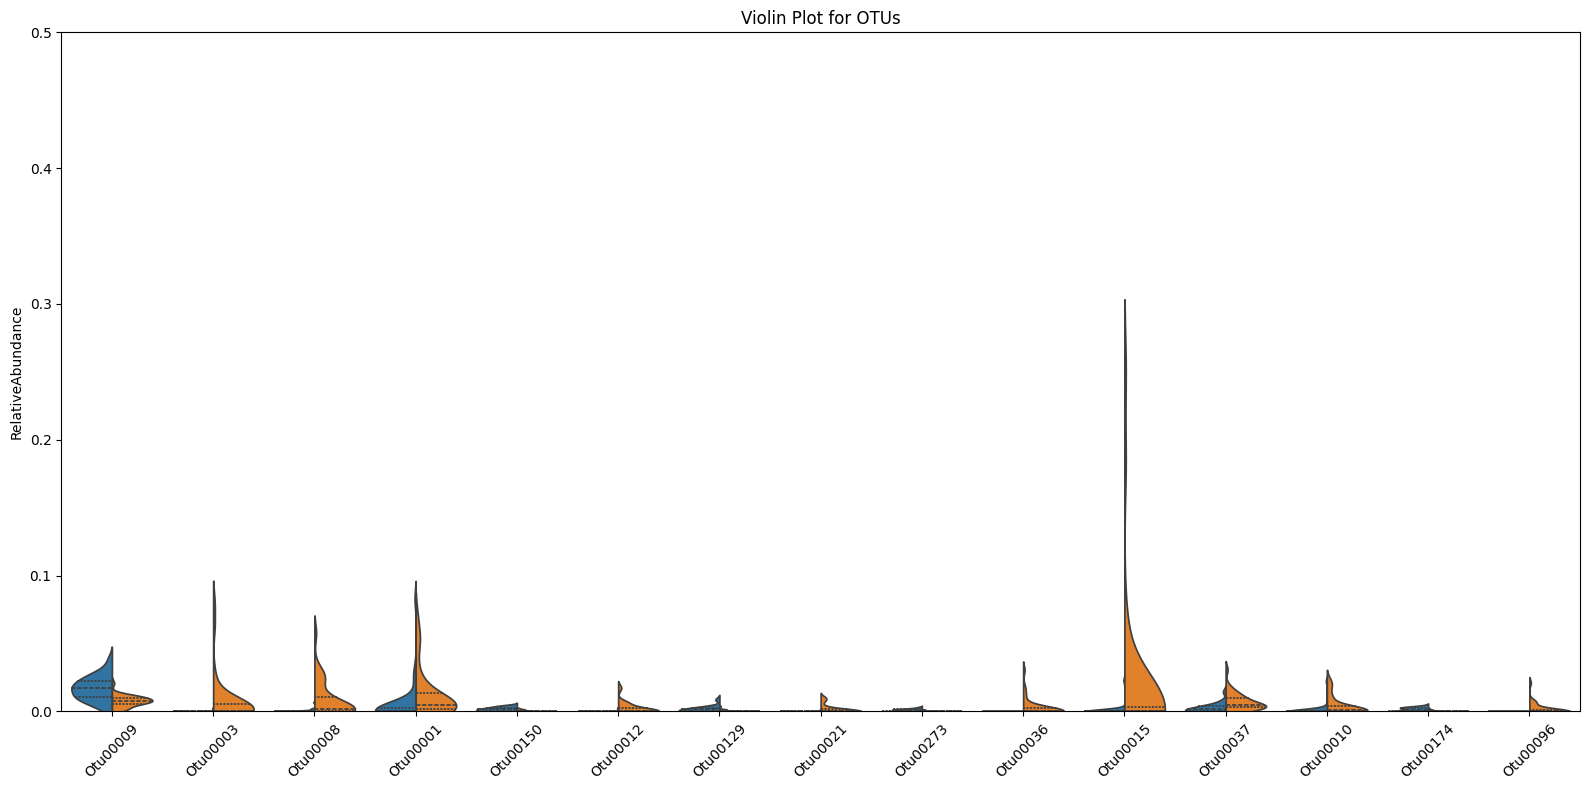

Index(['Clostridiales', 'Bacteroidales', 'Lactobacillales', 'Selenomonadales',
       'Bacilli_unclassified', 'Cardiobacteriales', 'Bacillales',
       'Thermoanaerobaculales', 'Pedosphaerales', 'Subgroup_6_or',
       'Enterobacteriales', 'Blastocatellales', 'Chitinophagales',
       'Cytophagales', 'Bacteria_unclassified'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                      OTU  presence_pos  presence_neg
0           Clostridiales      0.857143      0.325581
1           Bacteroidales      0.228571      0.000000
2         Lactobacillales      0.314286      0.046512
3         Selenomonadales      0.228571      0.000000
4    Bacilli_unclassified      0.257143      0.000000
5       Cardiobacteriales      0.314286      0.093023
6              Bacillales      0.771429      0.372093
7   Thermoanaerobaculales      0.000000      0.000000
8          Pedosphaerales      0.314286      0.767442
9           Subgroup_6_or      0.9428

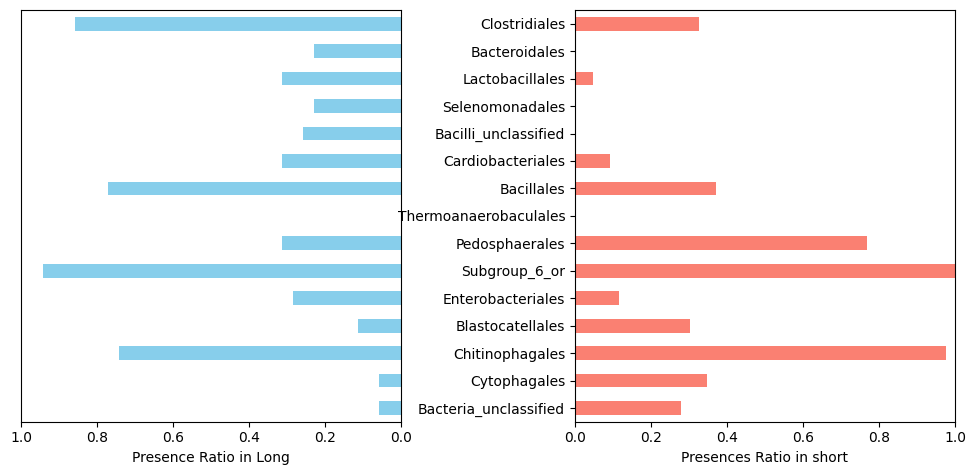

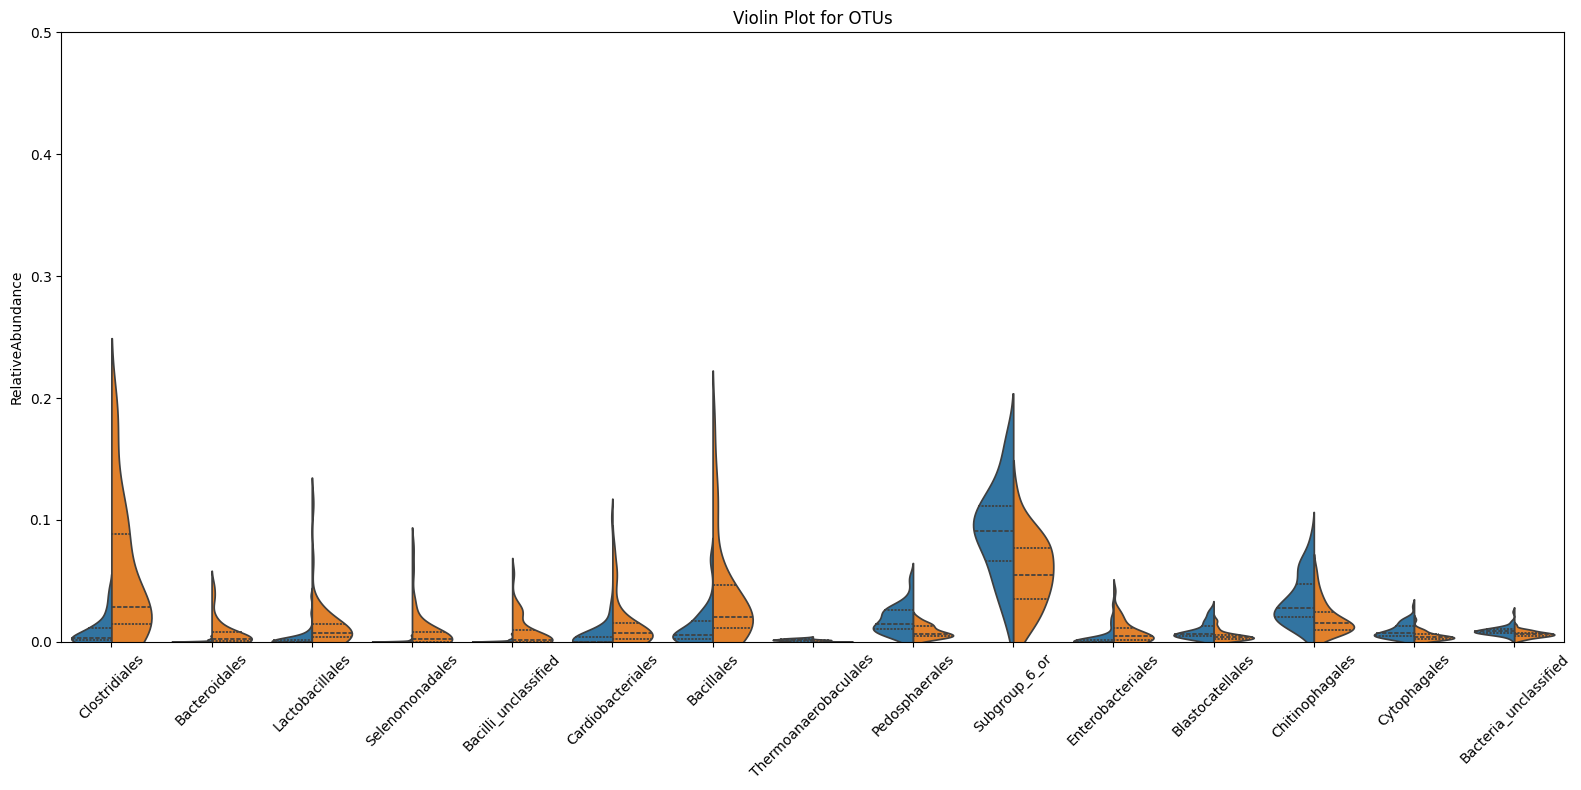

Index(['Clostridia', 'Bacilli', 'Negativicutes', 'Thermoanaerobaculia',
       'Subgroup_6', 'Deltaproteobacteria', 'Bacteria_unclassified',
       'Nitrospira', 'Holophagae', 'Subgroup_5', 'Blastocatellia_(Subgroup_4)',
       'Latescibacteria_cl', 'Subgroup_22', 'OLB14', 'Dehalococcoidia'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                            OTU  presence_pos  presence_neg
0                    Clostridia      0.857143      0.325581
1                       Bacilli      0.914286      0.441860
2                 Negativicutes      0.228571      0.000000
3           Thermoanaerobaculia      0.000000      0.000000
4                    Subgroup_6      0.942857      1.000000
5           Deltaproteobacteria      0.942857      0.976744
6         Bacteria_unclassified      0.057143      0.279070
7                    Nitrospira      0.000000      0.023256
8                    Holophagae      0.000000      0.023256
9          

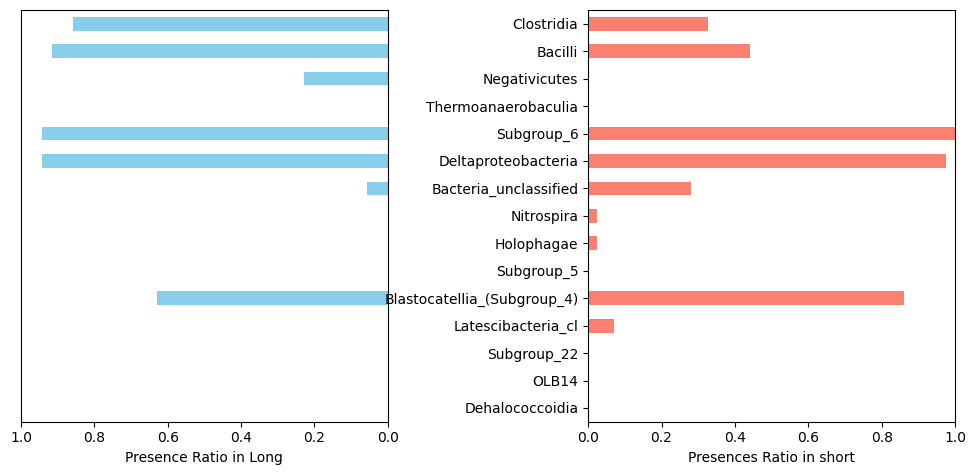

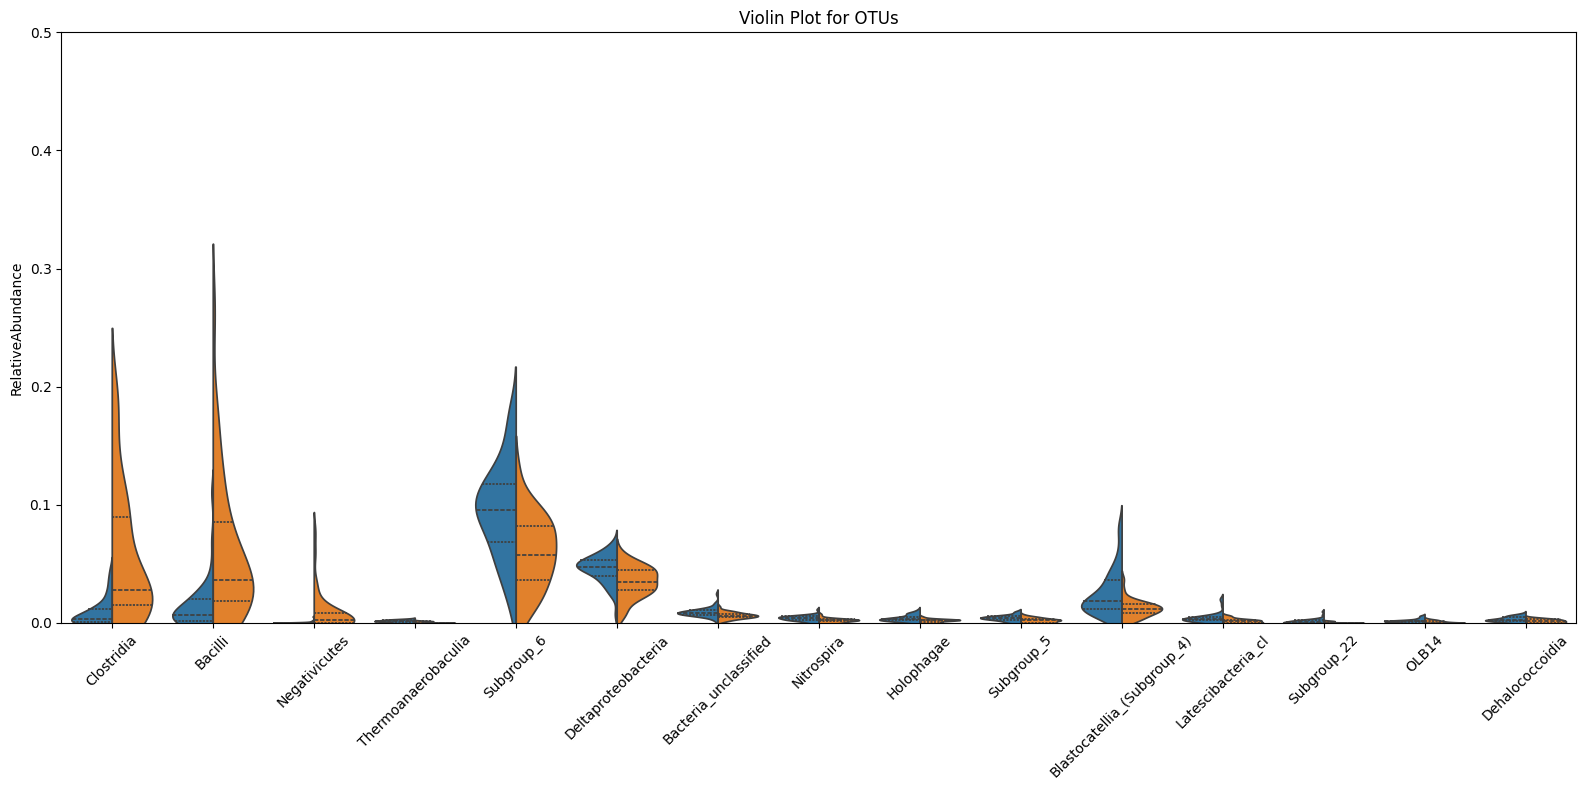

Index(['Firmicutes', 'Acidobacteria', 'Bacteria_unclassified', 'Nitrospirae',
       'Latescibacteria', 'Elusimicrobia', 'Verrucomicrobia',
       'Gemmatimonadetes', 'Epsilonbacteraeota', 'Armatimonadetes',
       'Planctomycetes', 'Bacteroidetes', 'Cyanobacteria', 'Fusobacteria',
       'Patescibacteria'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                      OTU  presence_pos  presence_neg
0              Firmicutes      1.000000      0.558140
1           Acidobacteria      0.971429      1.000000
2   Bacteria_unclassified      0.057143      0.279070
3             Nitrospirae      0.000000      0.023256
4         Latescibacteria      0.000000      0.069767
5           Elusimicrobia      0.000000      0.000000
6         Verrucomicrobia      1.000000      1.000000
7        Gemmatimonadetes      0.542857      0.697674
8      Epsilonbacteraeota      0.000000      0.000000
9         Armatimonadetes      0.000000      0.000000
1

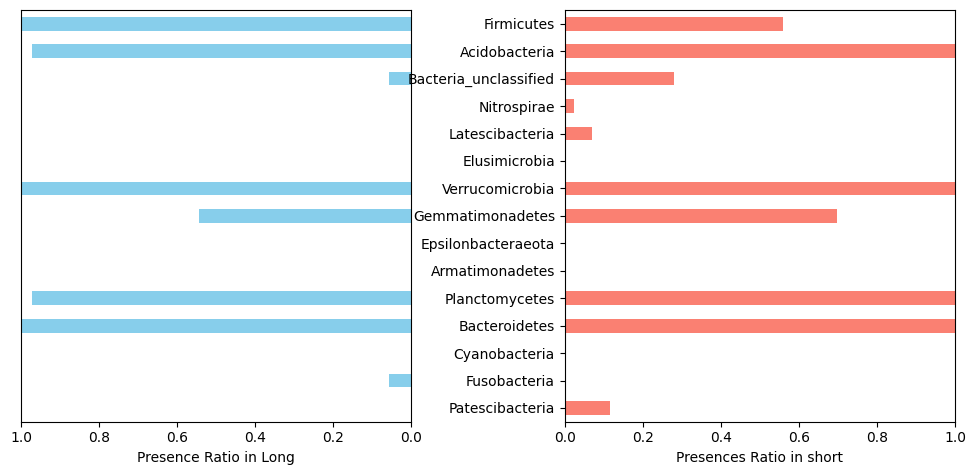

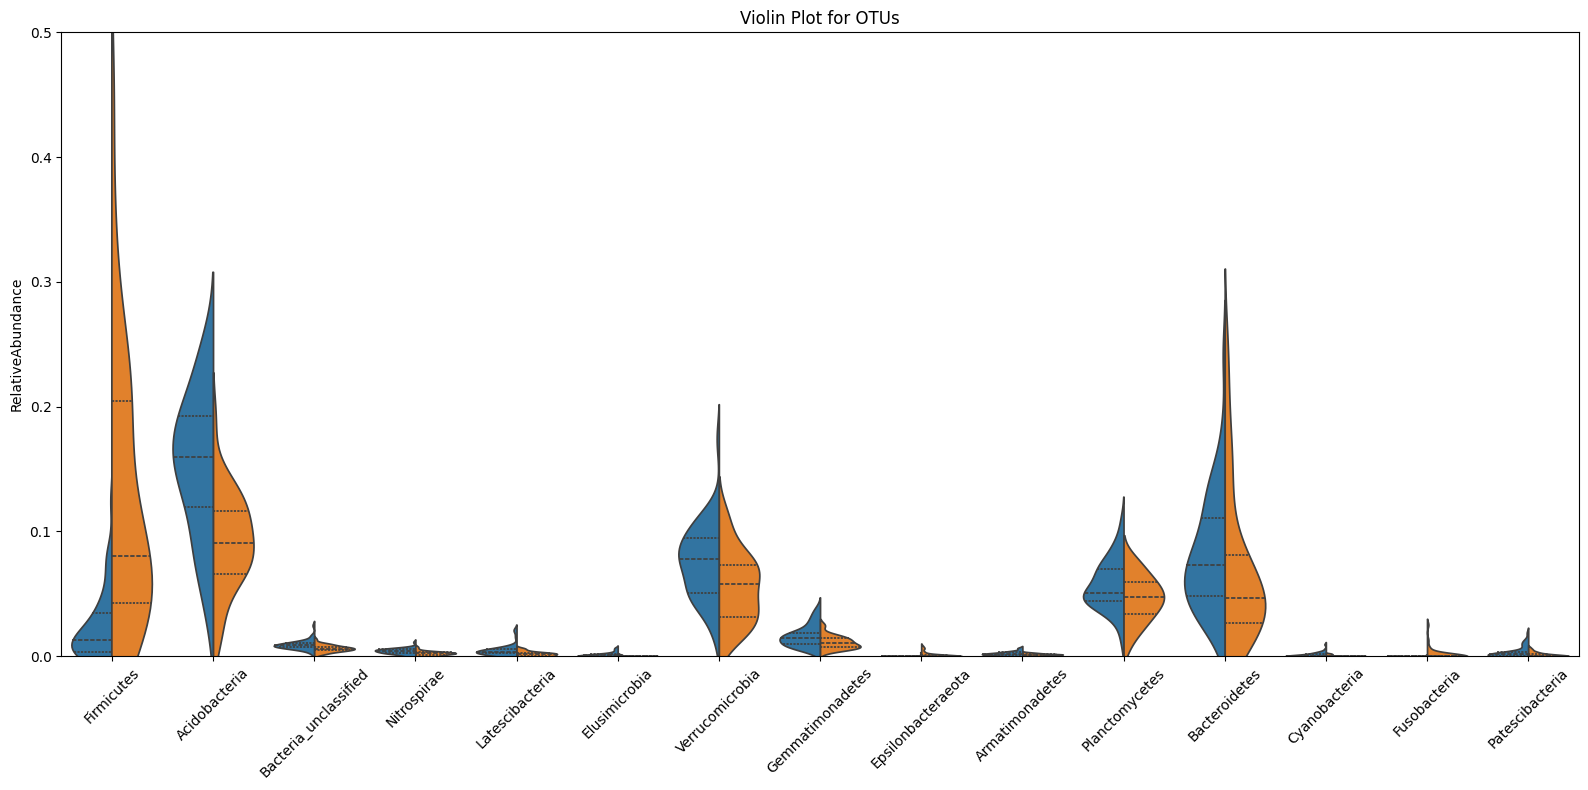

In [27]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15

for i, data_FS in enumerate(X_FS_4taxa):
    selectedASVs_15=selectedASVs_4taxa[i][:entries]
    print(selectedASVs_15)
    X_FS_15=data_FS[:,:entries]
    print(X_FS_15.shape)
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
    FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15,y_max=0.5)

Fine tuned Lasso selected Index(['Otu00007', 'Otu00008', 'Otu00036', 'Otu00080', 'Otu00105', 'Otu00135',
       'Otu00150', 'Otu00206', 'Otu00226', 'Otu00272', 'Otu00276', 'Otu00321',
       'Otu00418', 'Otu00559', 'Otu00601'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   Otu00007      0.285714      0.000000
1   Otu00008      0.257143      0.790698
2   Otu00036      0.228571      0.046512
3   Otu00080      0.057143      0.000000
4   Otu00105      0.085714      0.000000
5   Otu00135      0.028571      0.000000
6   Otu00150      0.000000      0.000000
7   Otu00206      0.000000      0.000000
8   Otu00226      0.000000      0.000000
9   Otu00272      0.000000      0.000000
10  Otu00276      0.000000      0.000000
11  Otu00321      0.000000      0.000000
12  Otu00418      0.000000      0.000000
13  Otu00559      0.000000      0.000000
14  Otu00601      0.000000      0.000000


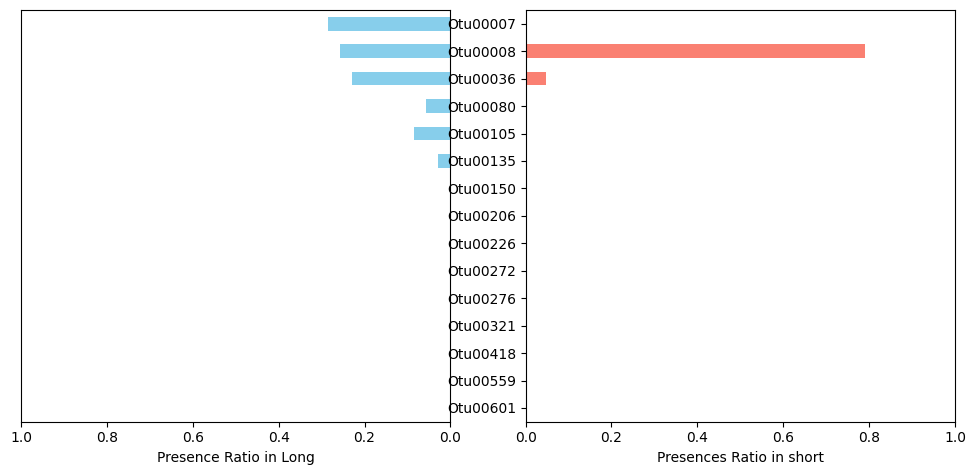

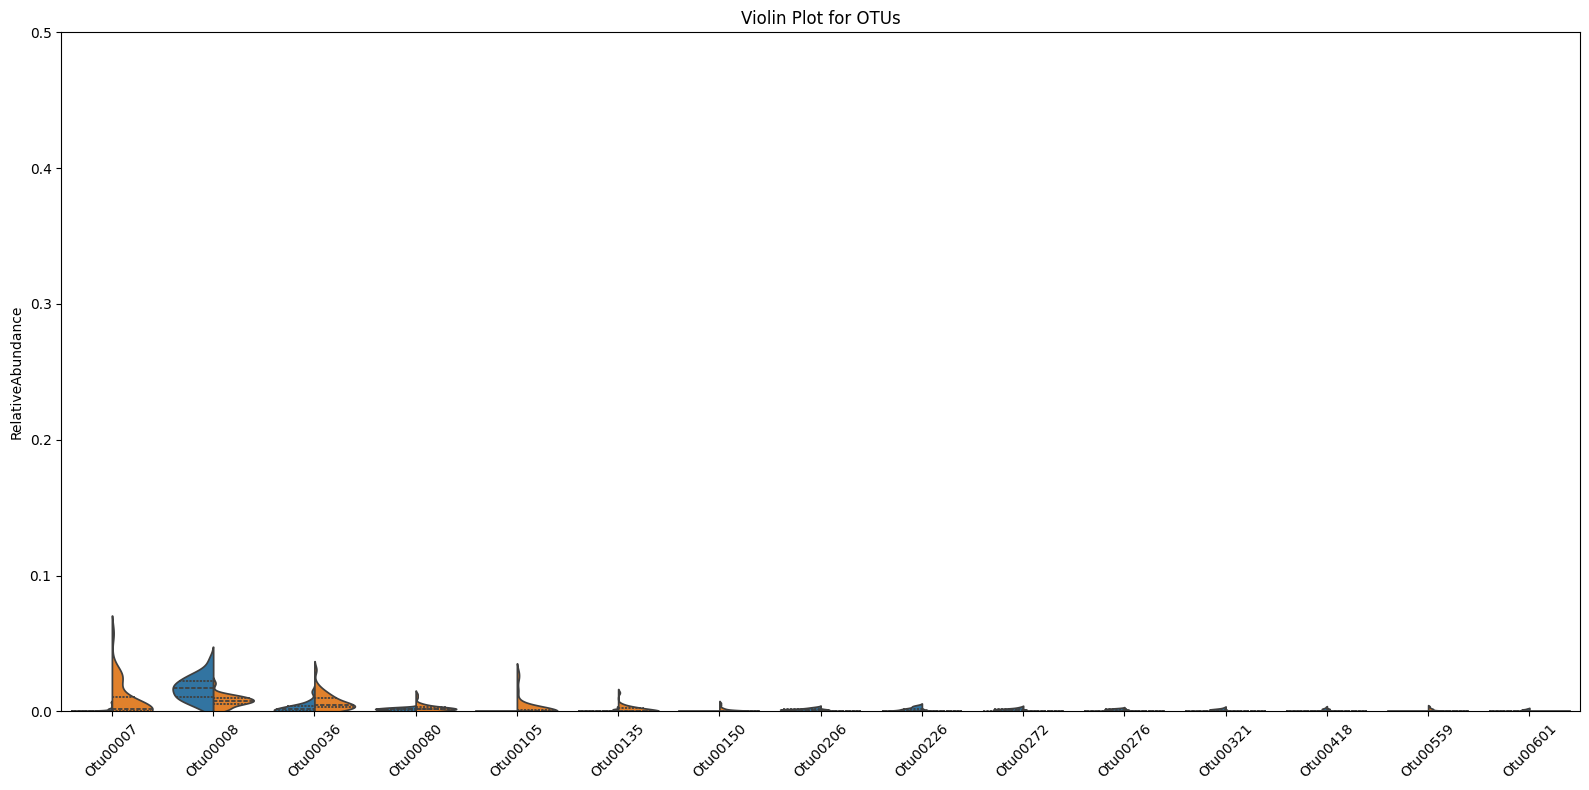

Fine tuned Lasso selected Index(['Pseudomonadales', 'Subgroup_6_or', 'Bacilli_unclassified',
       'Solirubrobacterales', 'Selenomonadales', 'Micromonosporales',
       'Subgroup_5_or', 'Ktedonobacterales', 'Pla4_lineage_or'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                    OTU  presence_pos  presence_neg
0       Pseudomonadales      0.857143      0.325581
1         Subgroup_6_or      0.257143      0.000000
2  Bacilli_unclassified      0.857143      0.558140
3   Solirubrobacterales      0.228571      0.000000
4       Selenomonadales      0.742857      0.976744
5     Micromonosporales      0.314286      0.767442
6         Subgroup_5_or      0.228571      0.000000
7     Ktedonobacterales      0.000000      0.023256
8       Pla4_lineage_or      0.000000      0.000000


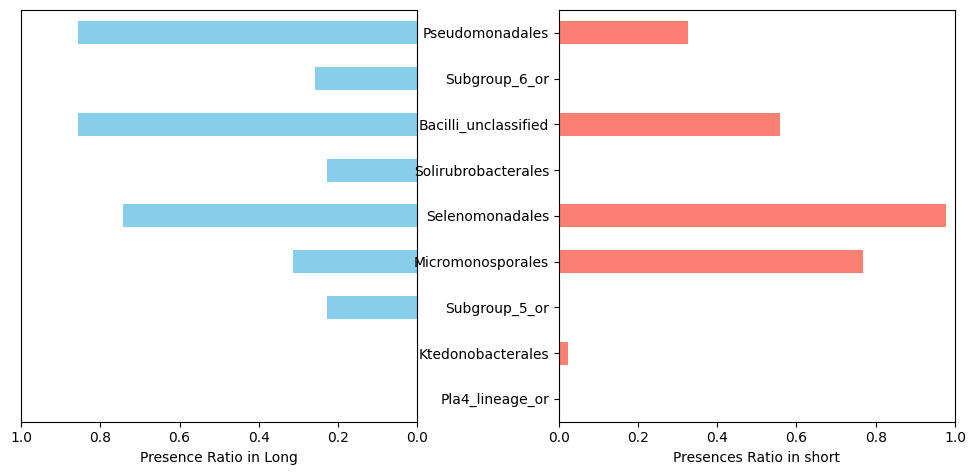

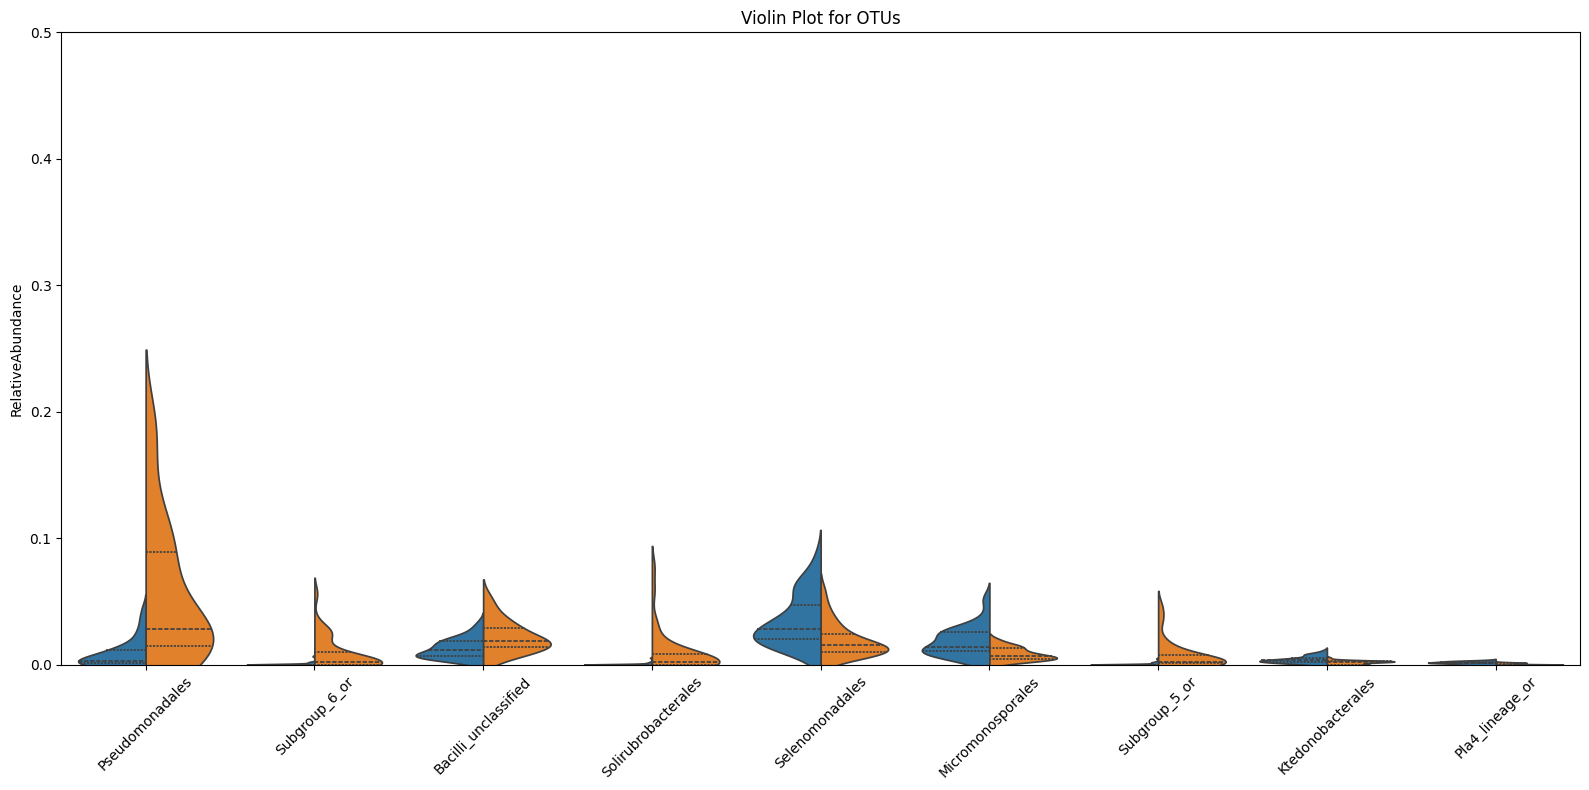

Fine tuned Lasso selected Index(['Gammaproteobacteria', 'Clostridia', 'Actinobacteria',
       'Thermoleophilia', 'Acidimicrobiia', 'Ktedonobacteria', 'Holophagae',
       'Actinobacteria_unclassified', 'Acidobacteriia', 'OLB14',
       'JG30-KF-CM66', 'Pla4_lineage', 'Chloroflexi_unclassified',
       'Saccharimonadia'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                            OTU  presence_pos  presence_neg
0           Gammaproteobacteria      0.857143      0.325581
1                    Clostridia      1.000000      1.000000
2                Actinobacteria      0.942857      0.976744
3               Thermoleophilia      0.228571      0.000000
4                Acidimicrobiia      0.000000      0.000000
5               Ktedonobacteria      0.000000      0.023256
6                    Holophagae      0.057143      0.000000
7   Actinobacteria_unclassified      0.000000      0.000000
8                Acidobacteriia      0.514286     

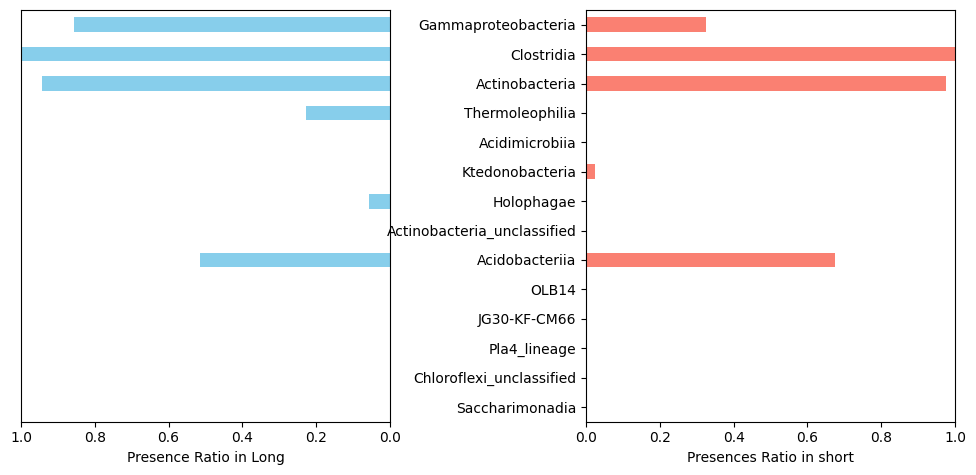

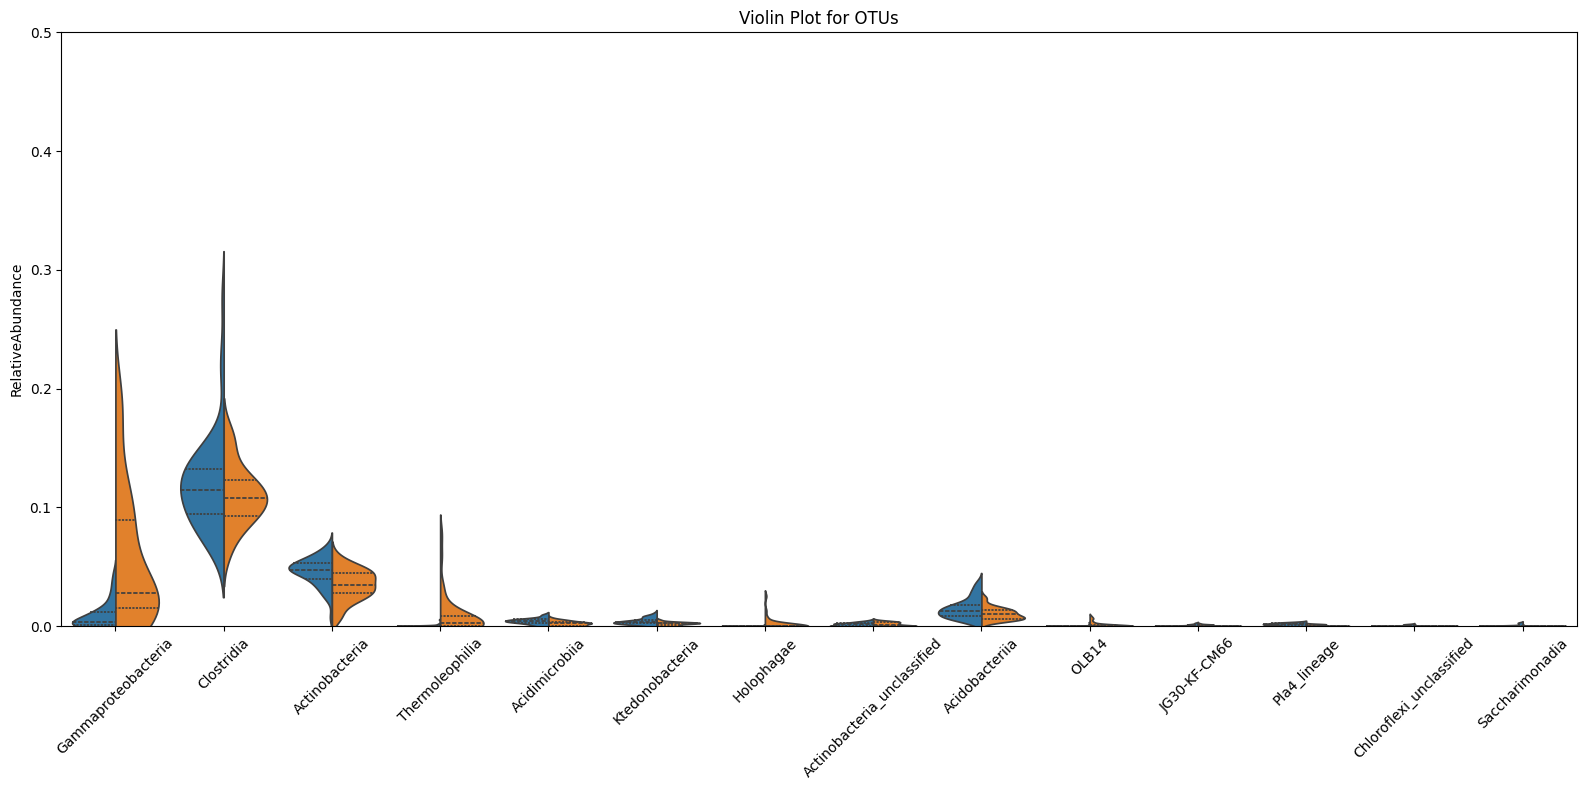

Fine tuned Lasso selected Index(['Verrucomicrobia', 'Actinobacteria', 'Nitrospirae',
       'Bacteria_unclassified', 'Latescibacteria', 'BRC1'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0        Verrucomicrobia      0.971429      1.000000
1         Actinobacteria      1.000000      0.558140
2            Nitrospirae      0.057143      0.000000
3  Bacteria_unclassified      0.542857      0.697674
4        Latescibacteria      0.000000      0.000000
5                   BRC1      0.000000      0.000000


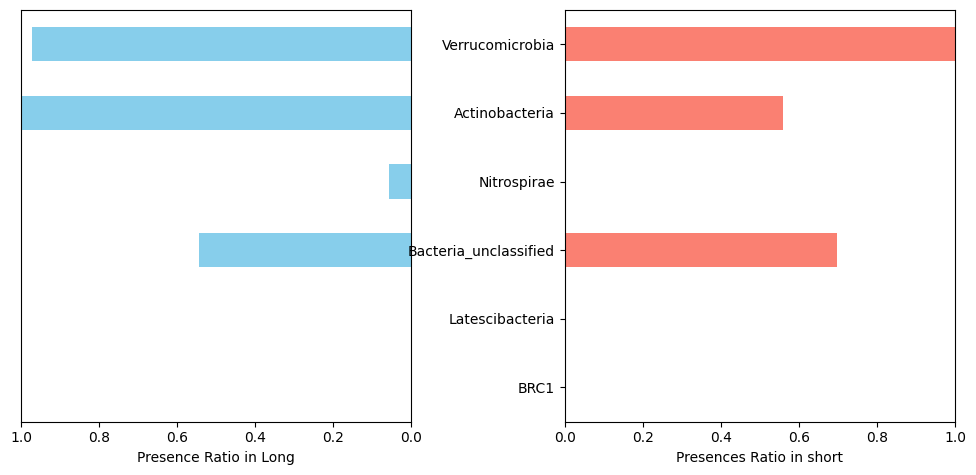

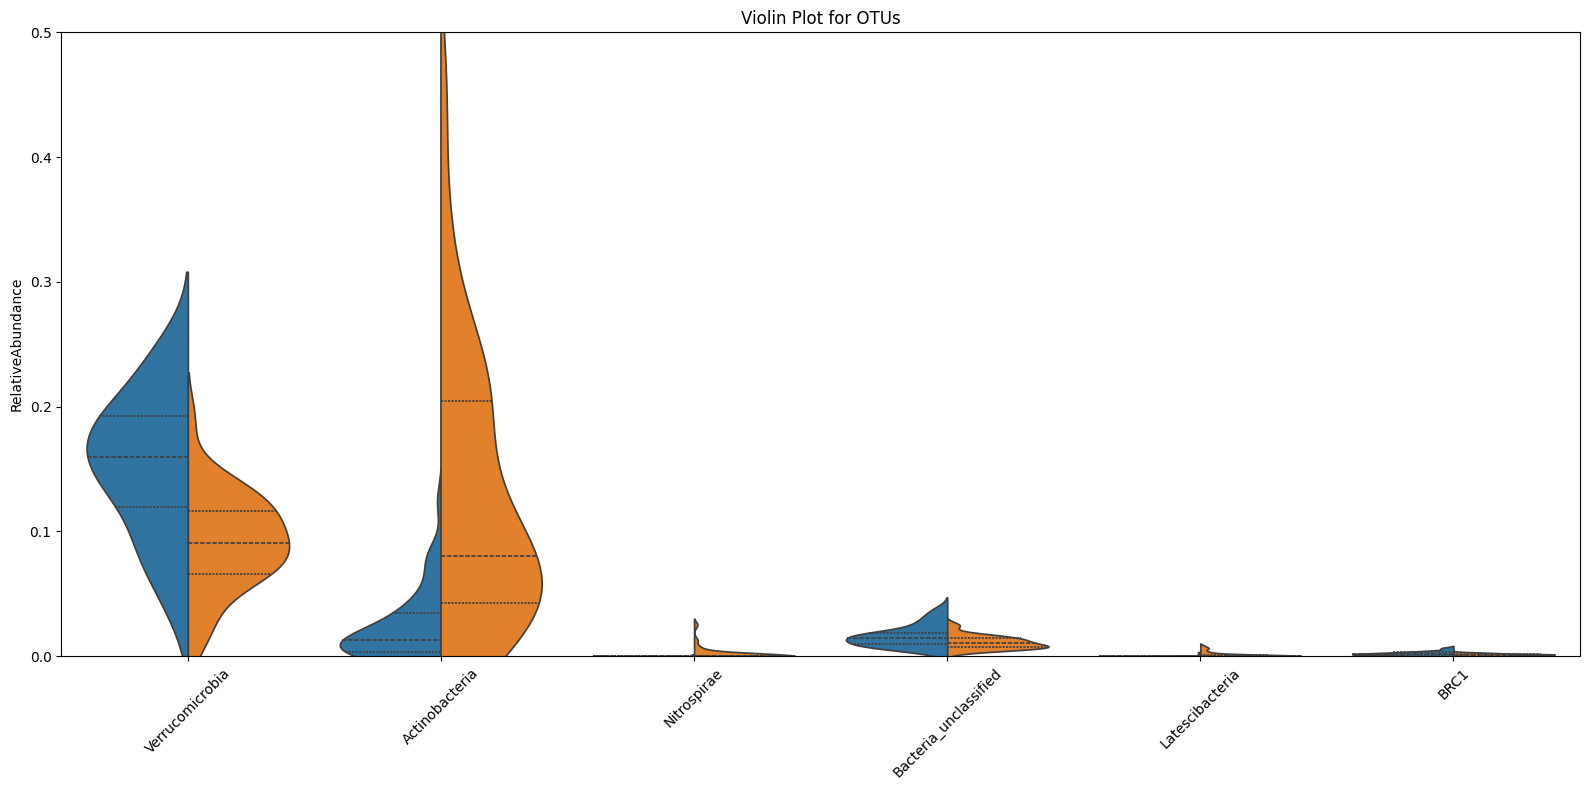

In [28]:
for i, data_FS in enumerate(X_lasso_ft_4taxa):
    selectedASVs_15=col_names_4taxa[i][xind_lasso_ft_4taxa[i]]
    print(f"Fine tuned Lasso selected {selectedASVs_15}")
    X_FS_15=data_4taxa[i][:,xind_lasso_ft_4taxa[i]]
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
    FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15,y_max=0.5) 
    

FS_Fine tuned Lasso selected Index(['Otu00008', 'Otu00007', 'Otu00272', 'Otu00014', 'Otu00036', 'Otu00206',
       'Otu00105', 'Otu00226', 'Otu00360', 'Otu00135', 'Otu00150', 'Otu00559',
       'Otu00601', 'Otu00080', 'Otu00276', 'Otu00281', 'Otu00463', 'Otu00778',
       'Otu00102', 'Otu00460', 'Otu00893', 'Otu00570', 'Otu00370', 'Otu00552',
       'Otu00639', 'Otu01074', 'Otu00772', 'Otu00472'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   Otu00008      0.257143      0.790698
1   Otu00007      0.285714      0.000000
2   Otu00272      0.000000      0.000000
3   Otu00014      0.171429      0.023256
4   Otu00036      0.228571      0.046512
5   Otu00206      0.000000      0.000000
6   Otu00105      0.085714      0.000000
7   Otu00226      0.000000      0.000000
8   Otu00360      0.000000      0.000000
9   Otu00135      0.028571      0.000000
10  Otu00150      0.000000      0.000000
11  Otu00559      0.0

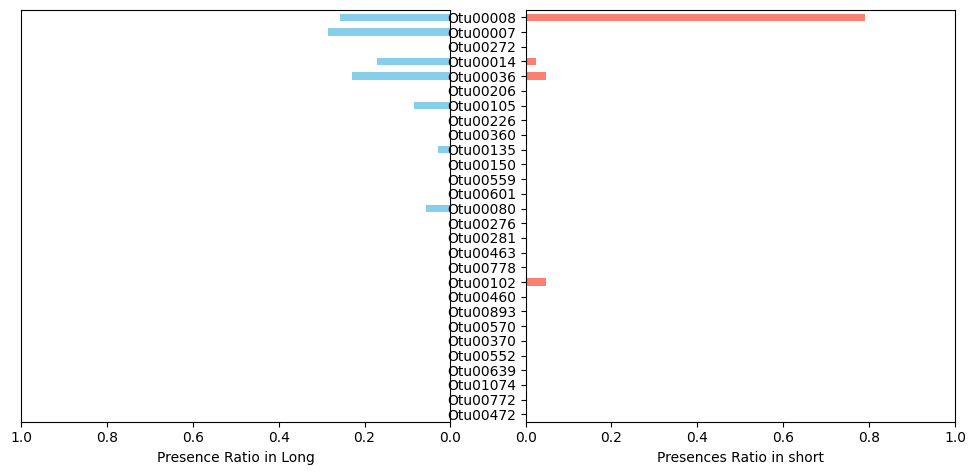

FS_Fine tuned Lasso selected Index(['Pseudomonadales', 'Subgroup_5_or', 'Solirubrobacterales',
       'Subgroup_6_or', 'Pla4_lineage_or', 'Micromonosporales',
       'Ktedonobacterales', 'Bacilli_unclassified', 'OLB14_or',
       'Streptomycetales', 'Dongiales', 'CCD24'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0        Pseudomonadales      0.857143      0.325581
1          Subgroup_5_or      0.228571      0.000000
2    Solirubrobacterales      0.228571      0.000000
3          Subgroup_6_or      0.257143      0.000000
4        Pla4_lineage_or      0.000000      0.000000
5      Micromonosporales      0.314286      0.767442
6      Ktedonobacterales      0.000000      0.023256
7   Bacilli_unclassified      0.857143      0.558140
8               OLB14_or      0.000000      0.000000
9       Streptomycetales      0.171429      0.511628
10             Dongiales      0.000000      0.000000
11   

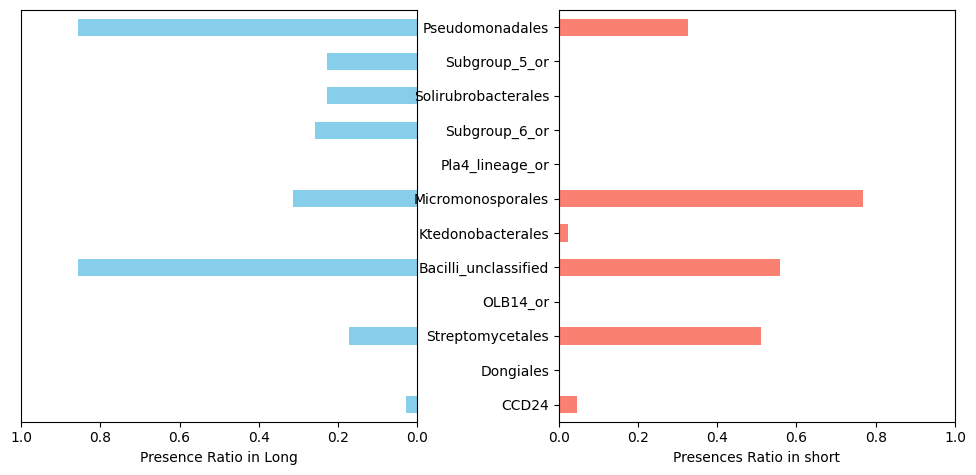

FS_Fine tuned Lasso selected Index(['Gammaproteobacteria', 'Deltaproteobacteria', 'Thermoleophilia',
       'Pla4_lineage', 'Actinobacteria', 'Ktedonobacteria', 'Acidimicrobiia',
       'Negativicutes', 'Latescibacteria_cl', 'Gitt-GS-136',
       'Alphaproteobacteria', 'OLB14', 'Chloroflexi_unclassified',
       'Subgroup_18', 'Subgroup_22', 'Saccharimonadia', 'Holophagae',
       'Subgroup_11', 'Anaerolineae', 'Campylobacteria', 'BRC1_cl', 'OM190'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                         OTU  presence_pos  presence_neg
0        Gammaproteobacteria      0.857143      0.325581
1        Deltaproteobacteria      0.914286      0.441860
2            Thermoleophilia      0.228571      0.000000
3               Pla4_lineage      0.000000      0.000000
4             Actinobacteria      0.942857      0.976744
5            Ktedonobacteria      0.000000      0.023256
6             Acidimicrobiia      0.000000      0.000000
7  

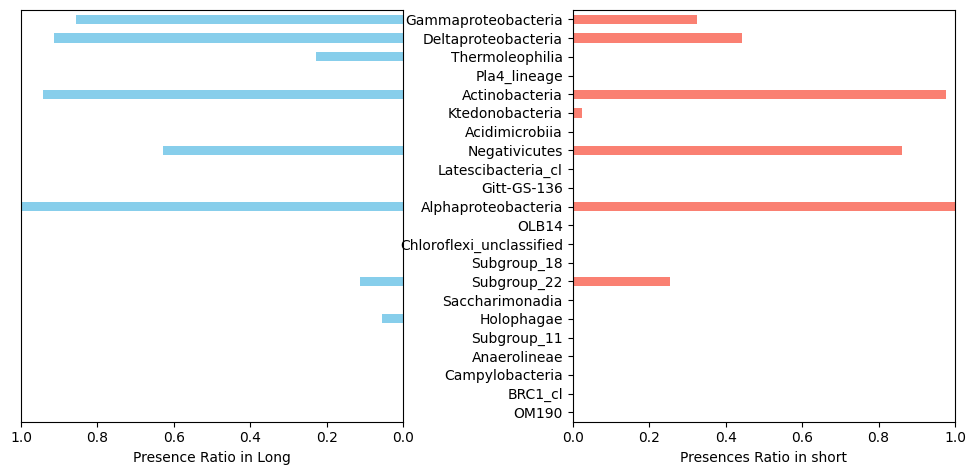

FS_Fine tuned Lasso selected Index(['Actinobacteria', 'Verrucomicrobia', 'Bacteria_unclassified',
       'Latescibacteria', 'BRC1', 'Nitrospirae'],
      dtype='object')
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0         Actinobacteria      1.000000      0.558140
1        Verrucomicrobia      0.971429      1.000000
2  Bacteria_unclassified      0.542857      0.697674
3        Latescibacteria      0.000000      0.000000
4                   BRC1      0.000000      0.000000
5            Nitrospirae      0.057143      0.000000


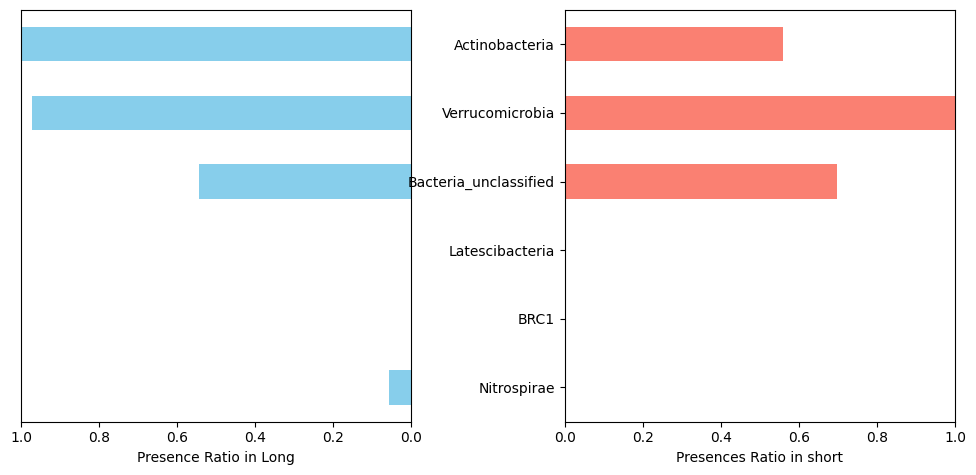

In [29]:
for i, data_FS in enumerate(X_FS_lassoft_4taxa):
    selectedASVs_15=col_names_4taxa[i][selectedOTU_index_FS_lassoft_4taxa[i]]
    print(f"FS_Fine tuned Lasso selected {selectedASVs_15}")
    X_FS_15=data_4taxa[i][:,selectedOTU_index_FS_lassoft_4taxa[i]]
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
  